In [68]:
import json
import numpy as np
from collections import defaultdict


def load_population_traces(path):
    with open(path, "r") as f:
        raw = json.load(f)

    history = raw.get("history", raw)
    best_gen = raw.get("best_gen", None)
    data = defaultdict(dict)
    for entry in history:
        gen = int(entry["generation"])
        for cand in entry.get("population", []):
            itr = int(cand.get("iteration", len(data[gen])))
            actions = [
                {
                    "action": int(step["action_index"]),
                    "logits": np.array(step["logits"], dtype=float),
                }
                for step in cand.get("actions", [])
            ]
            data[gen][itr] = {
                "return": float(cand.get("return", 0.0)),
                "actions": actions,
            }
    return data, best_gen

history_path = "/home/alnur/projects/rlo/runs/nonlinear/history.json"
log_data, best_gen = load_population_traces(history_path)


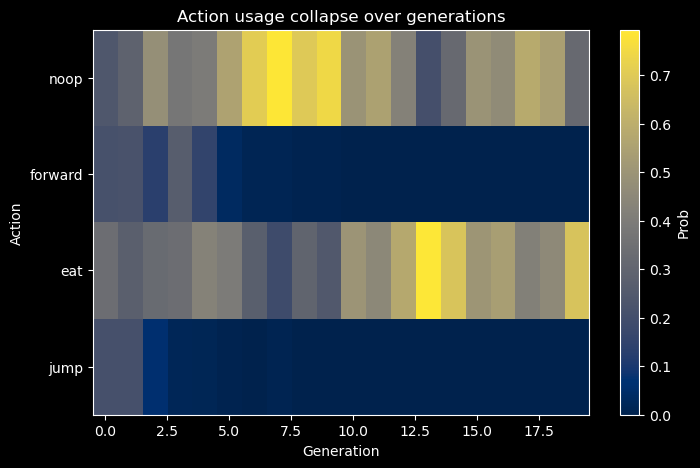

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../src/rlo")
from rlo import EndlessPlatformerEnv as env

def plot_action_heatmap(log_data, action_labels):
    num_actions = len(action_labels)
    action_names = [action_labels[i] for i in range(num_actions)]
    gens = sorted(log_data.keys())
    freqs = []

    for g in gens:
        acts = []
        for itr in log_data[g].values():
            acts += [x["action"] for x in itr["actions"]]
        hist = np.bincount(acts, minlength=num_actions)
        freqs.append(hist / hist.sum())

    freqs = np.array(freqs)

    plt.figure(figsize=(8,5))
    plt.imshow(freqs.T, aspect='auto', cmap='cividis')
    plt.colorbar(label="Prob")
    plt.xlabel("Generation")
    plt.ylabel("Action")
    plt.yticks(range(num_actions), action_names)
    plt.title("Action usage collapse over generations")
    plt.show()

plot_action_heatmap(log_data, env.ACTION_LABELS)


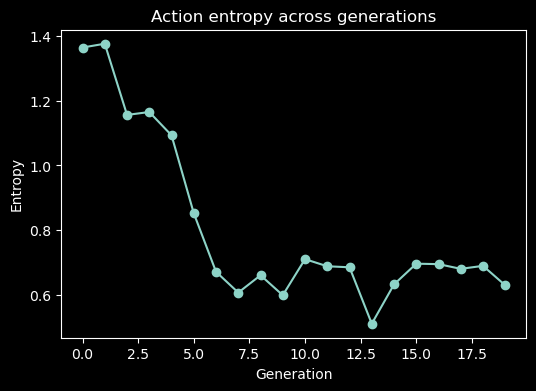

In [70]:
def plot_entropy(log_data):
    gens = sorted(log_data.keys())
    ent = []
    for g in gens:
        acts = []
        for itr in log_data[g].values():
            acts += [x["action"] for x in itr["actions"]]
        p = np.bincount(acts, minlength=4)
        # Shannon entropy
        p = p / p.sum()
        H = -np.sum(p * np.log(p + 1e-9))
        ent.append(H)

    plt.figure(figsize=(6,4))
    plt.plot(gens, ent, marker='o')
    plt.title("Action entropy across generations")
    plt.xlabel("Generation")
    plt.ylabel("Entropy")
    plt.show()

plot_entropy(log_data)


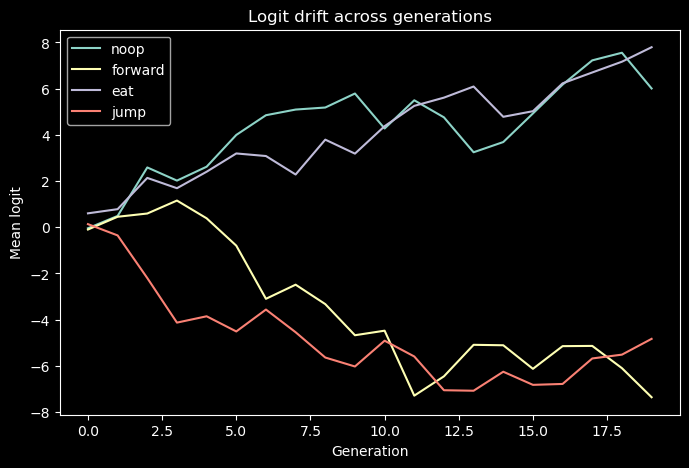

In [71]:
def plot_logit_drift(log_data, action_labels):
    num_actions = len(action_labels)
    action_names = [action_labels[i] for i in range(num_actions)]
    gens = sorted(log_data.keys())
    avg_logits = []

    for g in gens:
        logs = []
        for itr_data in log_data[g].values():
            logs.extend([item["logits"] for item in itr_data["actions"]])
        logs = np.array(logs)
        avg_logits.append(logs.mean(axis=0))

    avg_logits = np.array(avg_logits)

    plt.figure(figsize=(8,5))
    for i, name in enumerate(action_names):
        plt.plot(avg_logits[:, i], label=name)

    plt.legend()
    plt.set_cmap('cividis')
    plt.xlabel("Generation")
    plt.ylabel("Mean logit")
    plt.title("Logit drift across generations")
    plt.show()

plot_logit_drift(log_data, env.ACTION_LABELS)


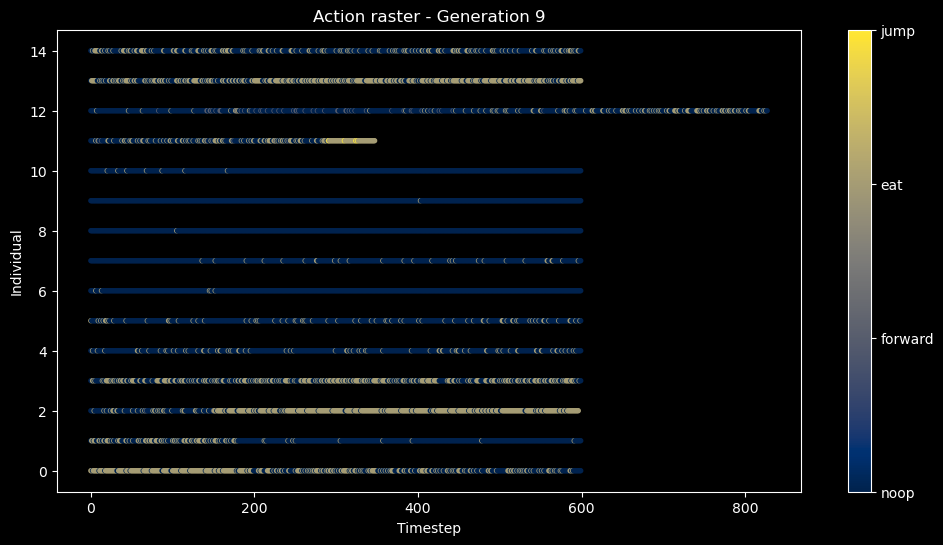

In [72]:
def plot_raster(log_data, gen, action_labels):
    num_actions = len(action_labels)
    action_names = [action_labels[i] for i in range(num_actions)]
    itrs = sorted(log_data[gen].keys())

    plt.figure(figsize=(12,6))

    for row_idx, itr in enumerate(itrs):
        actions = [x["action"] for x in log_data[gen][itr]["actions"]]
        plt.scatter(
            range(len(actions)),
            [row_idx]*len(actions),
            c=actions,
            cmap='cividis',
            s=8,
            vmin=0,
            vmax=num_actions-1
        )

    # custom colorbar with labels
    cbar = plt.colorbar()
    cbar.set_ticks(range(num_actions))
    cbar.set_ticklabels(action_names)

    plt.title(f"Action raster - Generation {gen}")
    plt.xlabel("Timestep")
    plt.ylabel("Individual")
    plt.show()

plot_raster(log_data, gen=best_gen, action_labels=env.ACTION_LABELS)


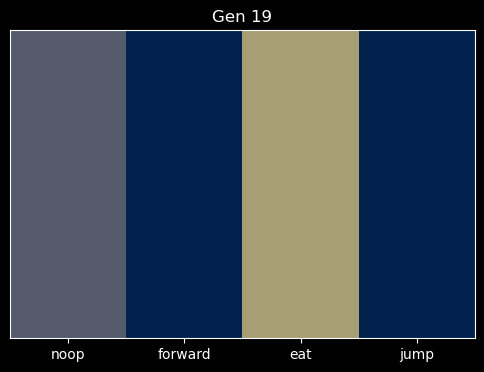

In [73]:
%matplotlib inline
from matplotlib import rc
rc('animation', html='jshtml')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_action_collapse(log_data, action_labels):
    num_actions = len(action_labels)
    action_names = [action_labels[i] for i in range(num_actions)]
    gens = sorted(log_data.keys())

    # compute frequencies
    freqs = []
    for g in gens:
        acts = []
        for itr in log_data[g].values():
            acts.extend([x["action"] for x in itr["actions"]])
        hist = np.bincount(acts, minlength=num_actions)
        freqs.append(hist / hist.sum())

    freqs = np.array(freqs)

    fig, ax = plt.subplots(figsize=(6,4))

    def update(frame):
        ax.clear()
        row = freqs[frame][None,:]
        ax.imshow(row, aspect='auto', cmap='cividis', vmin=0, vmax=1)
        ax.set_xticks(range(num_actions))
        ax.set_xticklabels(action_names)
        ax.set_yticks([])
        ax.set_title(f"Gen {gens[frame]}")

    ani = FuncAnimation(fig, update, frames=len(gens), interval=600)

    return HTML(ani.to_jshtml())

animate_action_collapse(log_data, env.ACTION_LABELS)


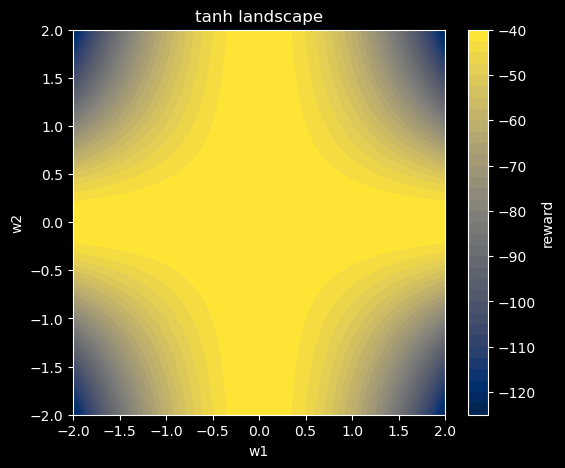

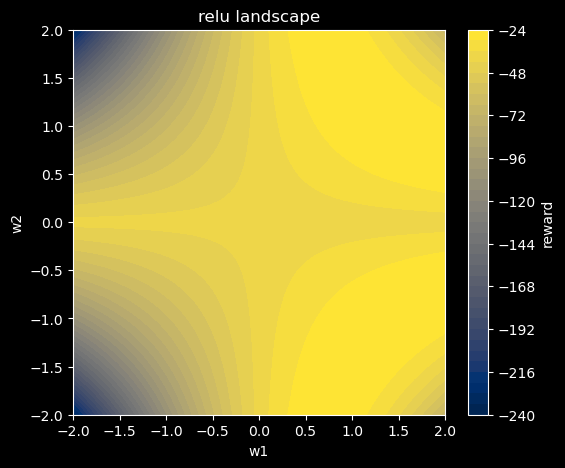

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# simple one hidden unit network
def net(x, w1, w2, activation="tanh"):
    h = w1 * x
    if activation == "tanh":
        h = np.tanh(h)
    elif activation == "relu":
        h = np.maximum(0, h)
    out = w2 * h
    return out

# simple reward function that likes output values near +1
def rollout(w1, w2, activation):
    total = 0
    xs = np.linspace(-1, 1, 40)
    for x in xs:
        y = net(x, w1, w2, activation)
        total += -((y - 1.0)**2)     # reward highest when y≈1
    return total

# sweep two weights
def compute_landscape(activation):
    grid = 60
    w_range = np.linspace(-2, 2, grid)
    Z = np.zeros((grid, grid))
    for i, w1 in enumerate(w_range):
        for j, w2 in enumerate(w_range):
            Z[i, j] = rollout(w1, w2, activation)
    return w_range, Z

# plot helper
def plot_landscape(w_range, Z, title):
    plt.figure(figsize=(6,5))
    plt.contourf(w_range, w_range, Z, levels=40)
    plt.set_cmap('cividis')
    plt.title(title)
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.colorbar(label="reward")
    plt.show()

# generate landscapes
for act in ["tanh", "relu"]:
    w_range, Z = compute_landscape(act)
    plot_landscape(w_range, Z, f"{act} landscape")


In [75]:
import numpy as np
import plotly.graph_objects as go

# simple one hidden unit network
def net(x, w1, w2, activation="tanh"):
    h = w1 * x
    if activation == "tanh":
        h = np.tanh(h)
    elif activation == "relu":
        h = np.maximum(0, h)
    return w2 * h

# simple reward
def rollout(w1, w2, activation):
    xs = np.linspace(-1, 1, 40)
    total = 0
    for x in xs:
        y = net(x, w1, w2, activation)
        total += -((y - 1.0)**2)
    return total

# compute grid
def compute_landscape(act):
    grid = 60
    wr = np.linspace(-2, 2, grid)
    Z = np.zeros((grid, grid))
    for i, w1 in enumerate(wr):
        for j, w2 in enumerate(wr):
            Z[i, j] = rollout(w1, w2, act)
    return wr, Z

# plot interactive 3d
def plot_interactive(act):
    wr, Z = compute_landscape(act)
    W1, W2 = np.meshgrid(wr, wr)
    
    fig = go.Figure(data=[
        go.Surface(x=W1, y=W2, z=Z, colorscale="Viridis")
    ])
    fig.update_layout(
        title=f"{act} 3D landscape",
        scene=dict(
            xaxis_title="w1",
            yaxis_title="w2",
            zaxis_title="reward"
        ),
        autosize=True,
        height=700
    )
    fig.show()

# generate both surfaces
plot_interactive("tanh")
plot_interactive("relu")
